# Entrainement DQN pour Space Invaders IA

In [10]:
import dqn
from game_environnement.space_invaders_game.Code.Main import Game
from game_environnement.space_invaders_env import SpaceInvadersEnv
from dqn.dqn_agent import train_dqn
from dqn.dqn_agent import DQNAgent

import pygame
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import os
import torch


In [11]:
pygame.init()

pygame.display.set_mode((100, 100))  

game = Game(600, 600, screen=None)
env = SpaceInvadersEnv(game)

In [12]:
print("=== DÉBUT DE L'ENTRAINEMENT DQN ===")
rewards = train_dqn(env, episodes=200)
print("=== FIN DE L'ENTRAINEMENT DQN ===")

=== DÉBUT DE L'ENTRAINEMENT DQN ===
Episode 1/200 - Reward: -51.15 - Epsilon: 0.995
Episode 2/200 - Reward: -7.10 - Epsilon: 0.990
Episode 3/200 - Reward: -18.43 - Epsilon: 0.985
Episode 4/200 - Reward: -25.99 - Epsilon: 0.980
Episode 5/200 - Reward: -10.90 - Epsilon: 0.975
Episode 6/200 - Reward: -16.18 - Epsilon: 0.970
Episode 7/200 - Reward: -23.68 - Epsilon: 0.966
Episode 8/200 - Reward: -18.07 - Epsilon: 0.961
Episode 9/200 - Reward: -11.76 - Epsilon: 0.956
Episode 10/200 - Reward: -5.18 - Epsilon: 0.951
Episode 11/200 - Reward: -5.68 - Epsilon: 0.946
Episode 12/200 - Reward: -20.89 - Epsilon: 0.942
Episode 13/200 - Reward: -28.58 - Epsilon: 0.937
Episode 14/200 - Reward: -99.92 - Epsilon: 0.932
Episode 15/200 - Reward: -16.96 - Epsilon: 0.928
Episode 16/200 - Reward: -18.15 - Epsilon: 0.923
Episode 17/200 - Reward: -18.73 - Epsilon: 0.918
Episode 18/200 - Reward: -17.49 - Epsilon: 0.914
Episode 19/200 - Reward: -17.70 - Epsilon: 0.909
Episode 20/200 - Reward: -104.95 - Epsilon: 0

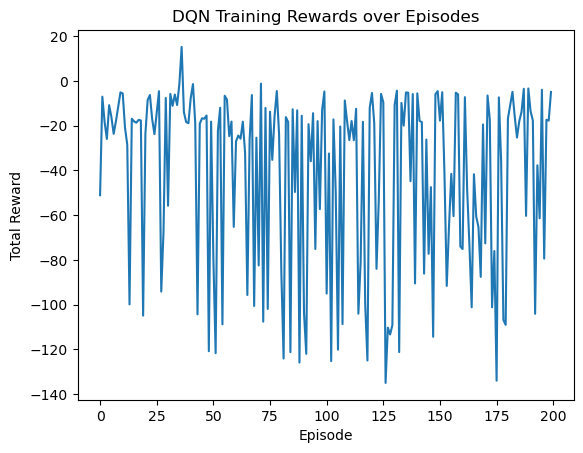

In [13]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Rewards over Episodes')
plt.show()

In [18]:
if "SDL_VIDEODRIVER" in os.environ:
    del os.environ["SDL_VIDEODRIVER"]
    print("Mode 'dummy' désactivé : La fenêtre devrait apparaître.")

try:
    pygame.quit()
except Exception:
    pass

# --- 1. CONFIGURATION ---
pygame.init()
screen_width = 600
screen_height = 600
screen = pygame.display.set_mode((screen_width, screen_height))
pygame.display.set_caption("Test Agent DQN Space Invaders")
clock = pygame.time.Clock()

# --- 2. ENVIRONNEMENT ---
game = Game(screen_width, screen_height, screen=screen)
env = SpaceInvadersEnv(game)

# --- 3. DÉTECTION TAILLE & AGENT ---
initial_state = env.reset()
#real_state_size = initial_state.shape[0]
real_state_size = 6
action_size = 4
agent = DQNAgent(real_state_size, action_size)

# --- 4. CHARGEMENT MODÈLE ---
model_path = "dqn_space_invaders_v3.pth"
device = torch.device("cpu") # CPU obligatoire pour éviter les conflits
agent.device = device 
agent.q_network.to(device)

try:
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'state_size' not in checkpoint:
        agent.q_network.load_state_dict(checkpoint)
    else:
        agent.q_network.load_state_dict(checkpoint)
    agent.q_network.eval()
    print("Cerveau de l'IA chargé !")
except FileNotFoundError:
    print(f"Fichier '{model_path}' introuvable.")
    pygame.quit()
    raise SystemExit

# --- 5. BOUCLE DE JEU ---
agent.epsilon = 0.0 # Mode expert
state = env.reset()
done = False
total_reward = 0

print("=== Lancement de la fenêtre graphique ===")

running = True
while running and not done:
    # Gestion des événements (Important pour que la fenêtre ne fige pas)
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # IA
    try:
        action = agent.act(state)
    except RuntimeError:
        print("Erreur de dimension état/modèle.")
        break
        
    state, reward, done = env.step(action)
    total_reward += reward

    # Rendu
    screen.fill((30, 30, 30))
    
    # Dessin des éléments
    if game.player.sprite.lasers: game.player.sprite.lasers.draw(screen)
    if game.player: game.player.draw(screen)
    if game.blocks: game.blocks.draw(screen)
    if game.aliens: game.aliens.draw(screen)
    if game.alien_lasers: game.alien_lasers.draw(screen)
    
    # Affichage du score (Optionnel, pour vérifier qu'il joue)
    font = pygame.font.Font(None, 36)
    score_text = font.render(f"Reward: {total_reward:.1f}", True, (255, 255, 255))
    screen.blit(score_text, (10, 10))

    pygame.display.flip()
    clock.tick(60) # 60 FPS pour que ce soit fluide

print(f"Score final : {total_reward}")
pygame.quit()

Cerveau de l'IA chargé !
=== Lancement de la fenêtre graphique ===
Score final : 196.9560000000008


## Épisodes de test

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_agent(env, agent, n_episodes=50):
    """
    Évalue les performances de l'agent sur n_episodes sans exploration.
    """
    print(f"--- Démarrage de l'évaluation sur {n_episodes} épisodes ---")
    
    # 1. Sauvegarder l'epsilon actuel et le mettre à 0 pour le test (Exploitation pure)
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    # Mettre le réseau en mode évaluation (pas de calcul de gradients inutile)
    agent.q_network.eval()
    
    game_scores = []      # Vrais scores du jeu (points affichés à l'écran)
    total_rewards = []    # Rewards cumulées (ce que l'IA optimise)
    steps_survived = []   # Durée de survie

    for i in range(n_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_steps = 0
        
        while not done:
            # L'agent choisit l'action (sans aléatoire car epsilon=0)
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            
            state = next_state
            episode_reward += reward
            episode_steps += 1
            
        # Fin de l'épisode
        game_scores.append(env.game.score) # On récupère le score interne du jeu
        total_rewards.append(episode_reward)
        steps_survived.append(episode_steps)
        
        if (i+1) % 10 == 0:
            print(f"Episode {i+1}/{n_episodes} - Score Jeu: {env.game.score} - Reward: {episode_reward:.2f}")

    # 2. Restaurer la configuration de l'agent
    agent.epsilon = original_epsilon
    agent.q_network.train() # Remettre en mode train si besoin
    
    # 3. Calcul des statistiques
    avg_score = np.mean(game_scores)
    std_score = np.std(game_scores)
    max_score = np.max(game_scores)
    
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(steps_survived)
    
    print("\n=== RÉSULTATS DE L'ÉVALUATION ===")
    print(f"Score Moyen (Jeu)   : {avg_score:.2f} ± {std_score:.2f}")
    print(f"Score Max (Jeu)     : {max_score}")
    print(f"Reward Moyenne (RL) : {avg_reward:.2f}")
    print(f"Survie Moyenne      : {avg_steps:.1f} steps")
    
    return game_scores, total_rewards

# --- Exécution de l'évaluation ---
# Assurez-vous que 'env' et 'agent' sont bien instanciés (ceux de votre fin d'entraînement)
test_scores, test_rewards = evaluate_agent(env, agent, n_episodes=50)

# --- Visualisation Graphique ---
plt.figure(figsize=(12, 5))

# 1. Histogramme des scores
plt.subplot(1, 2, 1)
plt.hist(test_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution des Scores de Jeu')
plt.xlabel('Score')
plt.ylabel('Nombre d\'épisodes')
plt.axvline(np.mean(test_scores), color='red', linestyle='dashed', linewidth=1, label=f'Moyenne: {np.mean(test_scores):.1f}')
plt.legend()

# 2. Boxplot (pour voir la stabilité)
plt.subplot(1, 2, 2)
plt.boxplot(test_scores)
plt.title('Dispersion des Scores (Stabilité)')
plt.ylabel('Score')
plt.xticks([1], ['Agent DQN'])

plt.tight_layout()
plt.show()

--- Démarrage de l'évaluation sur 50 épisodes ---


error: cannot convert without pygame.display initialized